# LayerNorm in DiT Viz

In DiT architecture, there is a LayerNorm before every layer. LayerNorm destroy the scale and shift information in its input.
However, we posit that this information is useful in the denoising task.

The StyleGAN-2 paper show that in a similar scenario, the generator is able to reduce the effect normalization by adding one very large value so that the normalization is approximately invertible.

This notebook aim to visualize the intermediary embeddings of the token in DiTs.
We see a similar behavior, which indicates that the network tries to bypass the layer normalization and thus that the scale and shift information is necessary and should be preserved.

# 1. Setup [from the original notebook]

> We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [ ]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

> ## Download DiT-XL/2 Models

> You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

We choose the 256x256 model for convenience

In [ ]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# 2. Load Data

To minimize potential sources of error, we load the data with the same procedure as in `train.py`.

In [12]:
data_path = '/dataset_root/ImageNet/val/' # Set the path to your dataset location
batch_size = 4

### Image Preprocessing

In [10]:
from torchvision import transforms
import numpy as np
from train import center_crop_arr

transform = transforms.Compose([
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
    ])

### Create dataloader and diffusion scheduler

In [13]:
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from diffusion import create_diffusion

dataset = ImageFolder(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size)

diffusion = create_diffusion(timestep_respacing="")

### Sample one batch

In [14]:
data_iterator = iter(dataloader)
x, y = next(data_iterator)
x = x.to(device)
y = y.to(device)
t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)

# 3. Visualize Latents

### Forward and return latents

In [17]:
# modified from DiT.forward in models.py
def get_latents(self, x, t, y):
    """
    Forward pass of DiT.
    x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
    t: (N,) tensor of diffusion timesteps
    y: (N,) tensor of class labels
    """
    x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
    t = self.t_embedder(t)                   # (N, D)
    y = self.y_embedder(y, self.training)    # (N, D)
    c = t + y                                # (N, D)
    latents = [x]
    for block in self.blocks:
        x = block(x, c)                      # (N, T, D)
        latents.append(x)
    x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
    latents.append(x)
    x = self.unpatchify(x)                   # (N, out_channels, H, W)
    return x, latents

In [18]:
with torch.no_grad():
    # Map input images to latent space + normalize latents:
    x = vae.encode(x).latent_dist.sample().mul_(0.18215)    
    model_output, latents = get_latents(model, x, t, y)

### Randomly select one token embedding per layer

In [20]:
import random

n_layers = len(latents)
random_latents = []

for latent in latents:
    flat = latent.reshape(-1, latent.shape[-1])
    random_latents.append(flat[random.randint(0,len(flat)-1)])

### Plot one random token embedding per layer

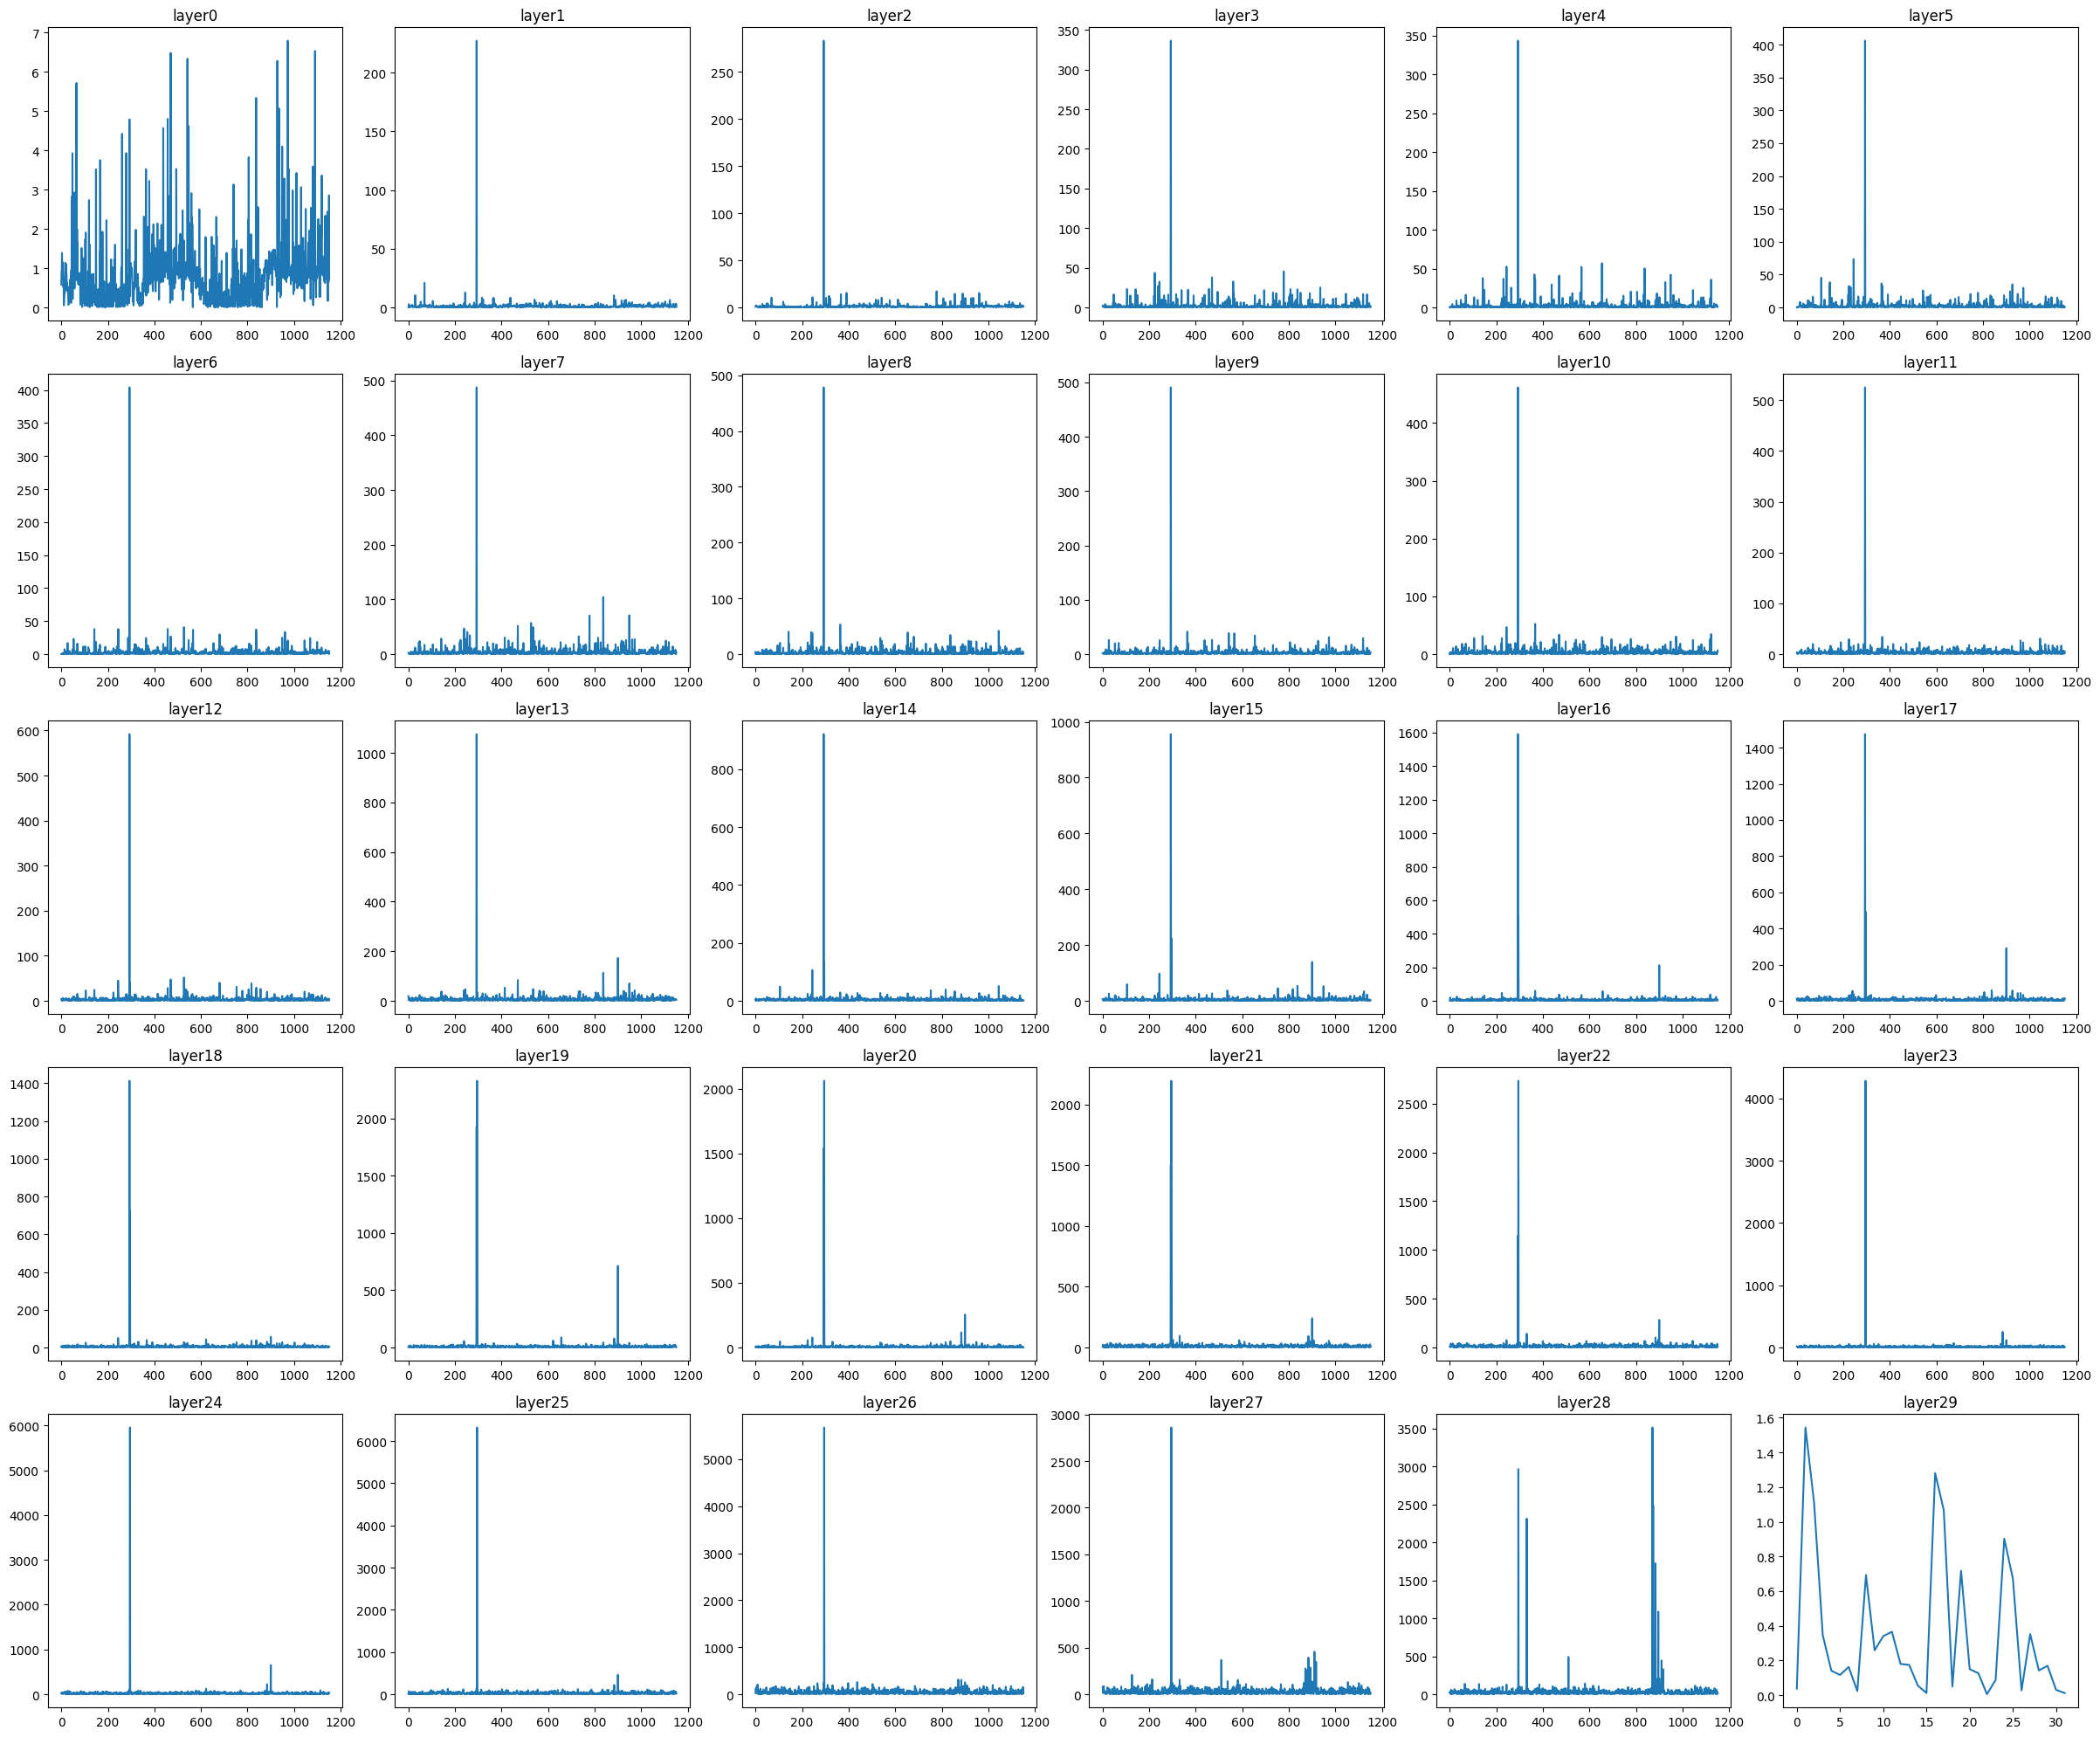

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 6, figsize=(24,20))

latents_iterator = iter(random_latents)
l = 0
for i in range(5):
    for j in range(6):
        latent = next(latents_iterator)
        axes[i][j].plot(range(len(latent)), latent.abs().cpu())
        axes[i][j].set_title(f"layer{l}")
        l += 1
        # axes[i][j].set_yscale('log')
fig.tight_layout()